# Natural Language Processing

Let's look at an example dealing with text data. Raw text data is an unstructured and ubiquitous type of data. Most of the world’s data is unstructured. Volumes of unstructured data, including text, are growing much faster than structured data. There are many industry estimates for the fraction of all data which is unstructured. How much text data are we talking about here? In a few years time, Twitter will have [more text data recorded](http://www.internetlivestats.com/twitter-statistics/) than all that has been written in print in the history of mankind.

Given the ubiquity and volume of text data, it is not surprising that numerous powerful applications which exploit text analytics are appearing. A few of these applications are listed below.

- Intelligent applications
  - Assistants
  - Chat bots
- Classification
  - Sentiment analysis
  - SPAM detection
- Speech recognition
- Search
- Information retrieval
- Legal discovery

In this tutorial we investigate two areas of text analytics:

- Pre-processing text data for analysis
- Classification of text and sentiment analysis

In [1]:
import string
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cProfile
import argparse
import pprint
import seaborn as sns

from nltk.corpus import stopwords
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')

# If you get an SSL-certificate error, and you are on a MAC then you may have to navigate to: application/python3/ and
# run/double-click on the command 'install certificates'.  Then try this again.

from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/standard/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/standard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The very first step to prepare text is to clean it.  We clean and normalize the text by performing various operations on the text. Some examples are as follows:

- Make the text lowercase.
- Remove symbols or punctuation.
- Remove numbers. May also replace all numbers with a numeric tag, for example `<NUM>` or similar. We may also consider replacing all dates with `<DATE>` or similarly use tags `<URL>`, `<PHONE>`, `<EMAIL>`, etc...
- Strip extra white space. White space has many forms: space, newline, or tab. There are also other rarely used unicode specifications for other white space characters.
- Remove all non-printable unicode characters.
- Replace accent characters.
- Remove 'stop words'. Stop words are generally non-informative words like "the", "as", "a", etc.
- Stem words to similar endings, such as "eats" and "eat".

There are a few reasons to clean your text.  The primary reason is to reduce the potential vocabulary and increase the observations of specific words (or tokens). Depending on the application, the above steps should be considered carefully and only applied when it makes sense. Ask yourself if words like "China" and "china" to be different.

**NOTE**: Be careful dealing with unicode characters. There are many editors and text viewers that only display printable characters but will not remove non-printable characters. Strange unicode characters can end up in data from users blindly copy/pasting text (with invisible unicode) into other text boxes.

### Exercise (8 minutes)

By its very nature, text data comes unstructured and poorly organized for analysis. Typically multiple steps are required to process text into a form suitable for analysis, starting with cleaning it.

Here's a horrible tweet. We're going to clean it and learn about ways to clean text data in the process.

In [3]:
horrible_tweet_text = 'I <3 cleaning data $\ \ $, it’s my \u1072  $\ \ $    fAvoRitE!! 11!!! I enjoy looking for bats in the closet'
print('Unfiltered text: \n{}\n'.format(horrible_tweet_text))

Unfiltered text: 
I <3 cleaning data $\ \ $, it’s my ၲ  $\ \ $    fAvoRitE!! 11!!! I enjoy looking for bats in the closet



Step by step, refine the above text. To avoid overwriting the existing string, you can create a new string from the string so far each time.

- Remove any non-ASCI character. A string `x` is ASCI if `ord(x) < 128`.

In [4]:
text = ''.join([x for x in horrible_tweet_text if ord(x) < 128])
print('Unfiltered text: \n{}\n'.format(text))

Unfiltered text: 
I <3 cleaning data $\ \ $, its my   $\ \ $    fAvoRitE!! 11!!! I enjoy looking for bats in the closet



- Make all the letters lower case.

In [5]:
text = text.lower()
print('Lower Case text: \n{}\n'.format(text))

Lower Case text: 
i <3 cleaning data $\ \ $, its my   $\ \ $    favorite!! 11!!! i enjoy looking for bats in the closet



- Remove all punctuation from the text. You can use `string.punctuation` to get a string of all punctuation characters.

In [6]:
punc = string.punctuation
text = ''.join([' ' if ele in punc else ele for ele in text])
print('Removed punctuation text: \n{}\n'.format(text))

Removed punctuation text: 
i  3 cleaning data         its my             favorite   11    i enjoy looking for bats in the closet



- Remove all the numbers from the text. HINT: If you are familiar with **regular expressions** you can use `re.sub` to do this easily.

In [7]:
text = re.sub(r'\d+', '', text)
print('Removed numbers text: \n{}\n'.format(text))

Removed numbers text: 
i   cleaning data         its my             favorite       i enjoy looking for bats in the closet



- Strip the text of any extra whitespace. HINT: The `split` method might help here.

In [8]:
text = ' '.join(text.split())
print('Removed white spaces text: \n{}\n'.format(text))

Removed white spaces text: 
i cleaning data its my favorite i enjoy looking for bats in the closet



- Remove all stop words from the text. We can use `stopwords.words('english')` to get a list of stop words for the English language.

In [9]:
text = ' '.join(['' if ele in stopwords.words('english') else ele for ele in text.split()])
print('Updated text: \n{}\n'.format(text))

Updated text: 
 cleaning data   favorite  enjoy looking  bats   closet



- Let's now use `WordNetLemmatizer()` to reduce the words to their **stems**. HINT: Use the object's `lemmatize` method.

In [11]:
lmtzr = WordNetLemmatizer()
word_list = text.split(' ')
stemmed_words = [lmtzr.lemmatize(word) for word in word_list]
text = ' '.join(stemmed_words)
print('Updated text: \n{}\n'.format(text))

Updated text: 
 cleaning data   favorite  enjoy looking  bat   closet



### End of exercise

Let's now combine the steps outlined in the above exercise and create a function to clean text for use. We will later use this function.

In [12]:
def preprocess(text, list_of_steps):
    
    for step in list_of_steps:
        if step == 'remove_non_ascii':
            text = ''.join([x for x in text if ord(x) < 128])
        elif step == 'lowercase':
            text = text.lower()
        elif step == 'remove_punctuation':
            punct_exclude = set(string.punctuation)
            text = ''.join(char for char in text if char not in punct_exclude)
        elif step == 'remove_numbers':
            text = re.sub("\d+", "", text)
        elif step == 'strip_whitespace':
            text = ' '.join(text.split())
        elif step == 'remove_stopwords':
            stops = stopwords.words('english')
            word_list = text.split(' ')
            text_words = [word for word in word_list if word not in stops]
            text = ' '.join(text_words)
        elif step == 'stem_words':
            lmtzr = WordNetLemmatizer()
            word_list = text.split(' ')
            stemmed_words = [lmtzr.lemmatize(word) for word in word_list]
            text = ' '.join(stemmed_words)
    return text

step_list = ['remove_non_ascii', 'lowercase', 'remove_punctuation', 'remove_numbers',
            'strip_whitespace', 'remove_stopwords', 'stem_words']

print("before: \"{}\"".format(horrible_tweet_text))
print("after : \"{}\"".format(preprocess(horrible_tweet_text, step_list)))

before: "I <3 cleaning data $\ \ $, it’s my ၲ  $\ \ $    fAvoRitE!! 11!!! I enjoy looking for bats in the closet"
after : "cleaning data favorite enjoy looking bat closet"


### Featurizing text data

We the clean data we can begin to ask what is the best way to extract features from the data. There are many more approaches for text analytics and natural language processing (NLP). We only mention a few below. Note that the collection of unique words in the data is called a **corpus**. To avoid having a corpus that's too large, we can trim the corpus by keeping the most frequent $N$ words, making $N$ the size of the corpus. A **document** usually refers to a single data point with raw text, such as a tweet, a review, an invoice, etc. So our documents are made up of "words" that come from the corpus (ignoring any words that are not in the corpus). The question now is how do we represent such a data numerically? Here are two approaches:

- The **bag of words model** is a simple and surprisingly effective model for analysis of text data. The BOW model creates a **sparse vector representation** of each word in the corpus based on the frequency of the words in the document. The order of the words is not considered, nor is the similarity between different words. Despite serious shortcomings, the model can work well in many cases.
- We can usually do much better by using **word embeddings**, which are **dense vector respresentations** for each word in the corpus. Word embeddings are learned by examining the word's **context** (other words around it). Word embeddings are very common in **deep learning** applications of NLP, although the embeddings themselves are learned using a shallow network. If we learn word embeddings from a very large data set once, we can save and re-use these word embeddings to create features for other data sets. In fact, **pre-trained word embeddings** are trained by large companies like Google and made available for use by others. So we can load these embeddings and numerically represent a document using the average of the embeddings of the words in it. Because word embeddings are vectors, such an average would also be a vector that is a dense representation of the document.

As you can see, BOW models seem too simplistic and word embeddings seem too sophisticated for now. So here's another approach that is sort of between the two in terms of difficulty. It is called TF-IDF and it is a clever way to featurize words in documents. Just like a BOW model, we begin by "tokenizing" the data. In BOW we then create a one-hot encoded feature for each token (or word). But in TF-IDF we first extract the relative word frequencies per document (called **term frequencies** or TF), we then multiply the term frequencies by a multiplier we call IDF. This has the effect of dampening the values for terms that appear frequently across documents, giving them less influence when we move on to the machine learning phase. Note that we used the words token, word and term almost interchangeably. Sorry for confusing you! Data scientists don't always agree on terminology. Let's dive in.

### Tokenize text

As a first step in preparing text for analysis of a document is to **tokenize** the text. In general terms, tokenization is the process dividing raw text into words, symbols and other elements, known as **tokens**. A set of tokens from all documents in the data is known as a **corpus**.

As a first step in creating a corpus is reading the data set. This particular data set is comprised of 160,000 tweets. The sentiment of these tweets has been human labeled as positive or negative (4 is for positive).

In [15]:
data_file = 'twitter_data.csv'
tweet_df = pd.read_csv(data_file)
tweet_df.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [16]:
tweet_df['sentiment_label'] = tweet_df['sentiment_label'].replace(4, 1)
tweet_df['sentiment_label'].value_counts()

1    80000
0    80000
Name: sentiment_label, dtype: int64

In [17]:
tweet_data = tweet_df.values.tolist()

Now that we have the data set read, we need to clean then tokenize the tweets. Note that stemming can be slow on large datasets.

In [18]:
steps = ['lowercase', 'remove_punctuation', 'remove_numbers', 'strip_whitespace', 'stem_words']
tweet_df['clean_tweet'] = tweet_df['tweet_text'].map(lambda s: preprocess(s, steps))

In [19]:
tweet_df.head()

,sentiment_label,tweet_text,clean_tweet
0,1,"@elephantbird Hey dear, Happy Friday to You A...",elephantbird hey dear happy friday to you alre...
1,1,Ughhh layin downnnn Waiting for zeina to co...,ughhh layin downnnn waiting for zeina to cook ...
2,0,"@greeniebach I reckon he'll play, even if he's...",greeniebach i reckon hell play even if he not ...
3,0,@vaLewee I know! Saw it on the news!,valewee i know saw it on the news
4,0,very sad that http://www.fabchannel.com/ has c...,very sad that httpwwwfabchannelcom ha closed d...


It's sometimes helpful to profile such functions to find the main culprits and see if we can do anything to speed them up.

In [20]:
import cProfile
cProfile.run("tweet_df['tweet_text'].map(lambda s: preprocess(s, steps))")

         46069728 function calls (46069726 primitive calls) in 14.295 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   160000    0.642    0.000   14.092    0.000 594333260.py:1(preprocess)
 11257197    1.053    0.000    1.053    0.000 594333260.py:10(<genexpr>)
   160000    0.524    0.000   10.503    0.000 594333260.py:23(<listcomp>)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(copyto)
   160000    0.144    0.000   14.236    0.000 <string>:1(<lambda>)
        1    0.005    0.005   14.295   14.295 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 base.py:2240(is_unique)
        1    0.000    0.000    0.000    0.000 base.py:4987(__contains__)
        1    0.000    0.000    0.000    0.000 base.py:7004(ensure_index)
        1    0.000    0.000    0.000    0.000 base.py:7099(maybe_extract_name)
        1    0.000    0.000   14.289   14.289 base.py:796(_map_values)
        1   

**NOTE:** To help us understand TF-IDF in great detail, we learn about TF-IDF in two different ways:

- We first run through the steps "manually", so that we can see talk about implementation details. 
- We then apply TF-IDF using `sklearn` in a few lines of code, which will hide all of that detail.

## Computing TF-IDF

Computing the TF-IDF values manually consist of several steps:
1. We obtain the term-document matirx. 
1. We calculate the **term-frequency (TF)** matirx, where $\text{TF(doc, term)}$ is the term frequencies from the term document matrix divided by the total number of terms in the document. In other words, we turn the frequencies into percentages (also called relative frequencies).
1. We trim the term-document matrix if needed. This gets rid of useless words that frequently appear across documents.
1. We can also derive the **inverse document frequencies (IDF)** matrix:

   $$\text{IDF(term)} = \log(\frac{\text{number of documents}}{\text{number of documents with term in it} })$$

   Note that TF is a function of both term and document, but the IDF is just a function of the terms.
1. We multiply the TF with IDF values to get TF-IDF values. This results in **term frequency inverse document frequency (TF-IDF) maxtrix**. 
   
   $$\text{TF-IDF} = \text{TF(term, doc)} \cdot \text{IDF(term)}$$

To get an intuition behind what's happening, here's what the IDF function looks like:

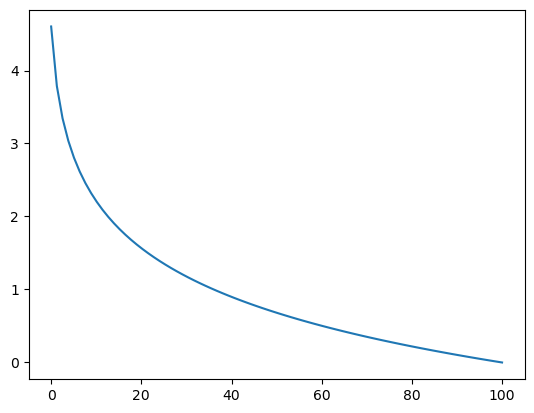

In [21]:
x = np.linspace(0, 100, num = 80)
sns.lineplot(x = x, y = np.log(100 / (x + 1)));

TFs give us the relative frequency terms in the documents. We use the IDFs to then dampen the TFs for terms that appear frequently across documents by virtue of being common terms. This will make it so rarer terms get to exert more influence during the machine learning phase.

Applications of TF-IDF include

- Characterize writing styles
- Comparing authors
- Determining original authors
- Finding plagiarism

Let's now implement this for the tweet data:

### Step 1: Get the term-document matrix

We first break up the words in the text:

In [22]:
clean_texts = tweet_df['clean_tweet']
docs = {}
labels = []
for ix, row in enumerate(clean_texts):
    labels = tweet_data[ix][0]
    docs[ix] = row.split(' ')

print('Example entry: {}'.format(docs[np.random.choice(ix)]))

Example entry: ['kkgirl', 'yes', 'you', 'are', 'd', 'imma', 'go', 'offline', 'tho', 'and', 'sulk', 'ttyl']


We can now create our corpus, keeping track of its size.

In [23]:
num_nonzero = 0
vocab = set()

for word_list in docs.values():
    unique_terms = set(word_list)    # all unique terms of this tweet
    vocab.update(unique_terms)       # set union: add unique terms of this tweet
    num_nonzero += len(unique_terms) # add count of unique terms in this tweet

doc_key_list = list(docs.keys())

print('Our tweet-vocabulary has {} distinct words.'.format(len(vocab)))

Our tweet-vocabulary has 146496 distinct words.


Let's now convert everything to a numpy array. We should keep track of how the vocab/term indices map to the matrix so that we can look them up later.

In [24]:
doc_key_list = np.array(doc_key_list)
vocab = np.array(list(vocab))

vocab_sorter = np.argsort(vocab)

print('Vocab: {}'.format(vocab[:5]))
print('Sorted Vocab: {}'.format(vocab[vocab_sorter[:20]]))

Vocab: ['prognosis' 'mothafucka' 'twitteriste' 'bismillah' 'chancequot']
Sorted Vocab: ['a' 'aa' 'aaa' 'aaaa' 'aaaaa' 'aaaaaa' 'aaaaaaa' 'aaaaaaaa' 'aaaaaaaaaa'
 'aaaaaaaaaaaa' 'aaaaaaaaaaaaa' 'aaaaaaaaaaaaaa' 'aaaaaaaaaaaaaaaa'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa' 'aaaaaaaaaaaaaaaaaaaaaaah'
 'aaaaaaaaaaaaaaaaaaaah' 'aaaaaaaaaaaaaaaaand' 'aaaaaaaaaaaaaaah'
 'aaaaaaaaaaaaaaahmmmmmmmmmm' 'aaaaaaaaaaaaaah']


We now initialize the **term-document matrix**. This is a matrix where each row $i$ is a document and each column $j$ is a word. The entriy $(i, j)$ of the matrix shows the frequency of the word $j$ in document $i$.

In [25]:
num_docs = len(doc_key_list)
vocab_size = len(vocab)
data = np.empty(num_nonzero, dtype = np.intc)     # all non-zero
rows = np.empty(num_nonzero, dtype = np.intc)     # row index
cols = np.empty(num_nonzero, dtype = np.intc)     # column index

We can now populate the term-document matrix: Each row $i$ is a document and each column $j$ is a word. The entriy $(i, j)$ of the matrix shows the frequency of the word $j$ in document $i$.

In [26]:
ix = 0
# go through all documents with their terms
print('Computing, please wait!')
for doc_key, terms in docs.items():
    # find indices to insert-into such that, if the corresponding elements were
    # inserted before the indices, the order would be preserved
    term_indices = vocab_sorter[np.searchsorted(vocab, terms, sorter = vocab_sorter)]

    # count the unique terms of the document and get their vocabulary indices
    uniq_indices, counts = np.unique(term_indices, return_counts = True)
    n_vals = len(uniq_indices)  # number of unique terms
    ix_end = ix + n_vals # add count to index

    data[ix:ix_end] = counts                  # save the counts (term frequencies)
    cols[ix:ix_end] = uniq_indices            # save the column index: index in 
    doc_ix = np.where(doc_key_list == doc_key)   # get the document index for the document name
    rows[ix:ix_end] = np.repeat(doc_ix, n_vals)  # save it as repeated value

    ix = ix_end  # resume with next document -> will add future data on the end

print('Done!')

Computing, please wait!
Done!


Let's look at our sorted vocabulary again.

In [27]:
print('First five terms alphabetically: {}'.format(vocab[vocab_sorter[:5]]))

First five terms alphabetically: ['a' 'aa' 'aaa' 'aaaa' 'aaaaa']


As you can see, we probably need to do some trimming, as the word 'aaaaa' probably doesn't occur often enough, and having 151,670 unique words may be too much.  We will address this later on. For now, let's keep the corpus we have. We now initialize a sparse matrix that will store the term-document matirx.

In [28]:
doc_term_mat = coo_matrix((data, (rows, cols)), shape = (num_docs, vocab_size), dtype = np.intc)

doc_term_mat 

<160000x146496 sparse matrix of type '<class 'numpy.int32'>'
	with 1957413 stored elements in COOrdinate format>

We can now populate the matrix with the term frequencies. We can see an example of this for the word "python" in the code below.

In [29]:
# let's check to make sure!
vocab_list = list(vocab)
word_of_interest = 'python'
vocab_interesting_ix = list(vocab).index(word_of_interest)
print('vocab index of {} : {}'.format(word_of_interest, vocab_interesting_ix))
# find which tweets contain word
doc_ix_with_word = []
for ix, row in enumerate(tweet_data): # note on this line later
    if word_of_interest in row[1]:
        doc_ix_with_word.append(ix)

print('\n1st document index containing said word: {}'.format(doc_ix_with_word[0]))
print('\nTweet: {}'.format(tweet_data[doc_ix_with_word[0]]))

vocab index of python : 6272

1st document index containing said word: 14592

Tweet: [1, "omg, I just found my old vid of monty python's life of brian. it's brilliant, I just can't get enough stan today"]


We can see that the word "python" appears once in the first document (tweet).

**Note:** The term-document matirx `doc_term_mat` is a sparse matirx. So we can't index it using row and column index. Here we don't really need to do that, but if we did we would first need to convert it into an array. We can use the `toarray` method to do that, but if the matrix is large we can easily run out of memory (that's why we're using a spares matrix in the first place!). So instead we can use the `tocrs` method shown below, which uses compression to avoid the memory problem.

In [30]:
# document - term matrix relevant entry
document_row = doc_ix_with_word[0]
vocab_col = vocab_interesting_ix
mat_entry = doc_term_mat.tocsr()[document_row, vocab_col]

print('\nRow {} and column {} of document-term matrix has entry {}'.format(document_row, vocab_col, mat_entry))


Row 14592 and column 6272 of document-term matrix has entry 1


### Step 2: Trimming the document-term matrix

We saw above that we are including terms like 'aaaaa' and 'aaaa', which probably occur very few times. These terms generally occur with unstructured text fields because we allow users to input whatever they feel like and that includes typos.  But be aware that they can also be artifacts of our cleaning process (unintentionally and intentionally).

Since our document-term matrix is a matrix of counts of words (columns) in each document (rows), we want to remove words that don't occur very frequently across our corpus. The count of how frequent a word is in all of our corpus is just the sum of each column.

In [30]:
word_counts = doc_term_mat.sum(axis = 0)
print(word_counts)

[[1 5 1 ... 2 1 5]]


Let's look at how many words are above a specific cutoff, such as 15:

In [31]:
cutoff = 15
word_count_list = word_counts.tolist()[0]
col_cutoff_ix = [ix for ix, count in enumerate(word_count_list) if count > cutoff]

print('Number of words w/counts above {} : {}'.format(cutoff, len(col_cutoff_ix)))

Number of words w/counts above 15 : 5856


We can now trim our vocabulary and document term matrix.

In [32]:
vocab_trimmed = np.array([vocab[x] for x in col_cutoff_ix])
vocab_sorter_trimmed = np.argsort(vocab_trimmed)

print('Shape of document-term matrix before trimming: {}'.format(doc_term_mat.shape))

doc_term_mat_trimmed = doc_term_mat.tocsc()[:, col_cutoff_ix]
print('Shape of document-term matrix after trimming: {}'.format(doc_term_mat_trimmed.shape))

Shape of document-term matrix before trimming: (160000, 146496)
Shape of document-term matrix after trimming: (160000, 5856)


In [33]:
# Look at first 10 words alphabetically
vocab_trimmed[vocab_sorter_trimmed[0:10]]

array(['a', 'aa', 'aaa', 'aaaah', 'aaah', 'aah', 'aaron', 'ab',
       'abandoned', 'abby'], dtype='<U37')

How do we know what cutoff we should use? Let's look at a bar plot words in descending frequency before and after we trimmed it.

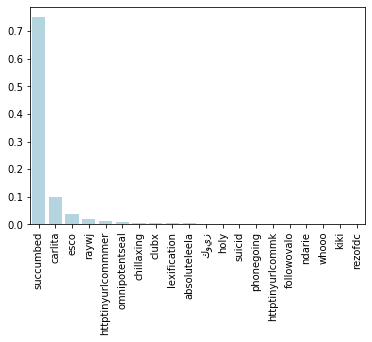

In [34]:
counts = pd.value_counts(word_count_list, normalize = True)[:20]
words = [vocab[x] for x in counts.index][:20]
g = sns.barplot(x = words, y = counts, color = 'lightblue')
g.set_xticklabels(rotation = 90, labels = words);

We can see the bar plot is very skewed. There are too many words that appear few times. Let's check out the trimmed list.

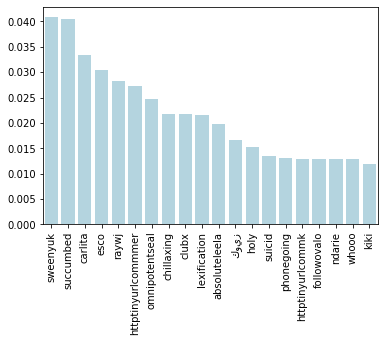

In [35]:
trimmed_word_counts = doc_term_mat_trimmed.sum(axis = 0)
trimmed_word_list = trimmed_word_counts.tolist()[0]

counts = pd.value_counts(trimmed_word_list, normalize = True)[:20]
counts = counts.reset_index(drop = True)
words = [vocab[x] for x in counts.index][:20]
g = sns.barplot(x = words, y = counts, color = 'lightblue')
g.set_xticklabels(rotation = 90, labels = words);

Note that 15 might be a good cutoff because we get a visible drop off and around 6000 features, but these types of **hyperparameters** for the model will probably need tuning. We will learn about tuning such values in future lectures.

### Step 3: Compute IDF

### Computing Term Frequency

Now that we have computed a document-term matrix, how can we understand it? Recall that the simple **Bag of Words model** is just based on **Term Frequency (TF)**. In this case, the weighting of a document for a given term is just the frequency of that term in the document. 

In other cases we will used the **Inverse Document Frequency (IDF)** weighting. IDF weighting accounts for cases where only a few documents contain certain terms. The formula for the IDF weighting can be written as:

$$IDF = log(\frac{Number\ Documents}{Number\ Documents\ with\ Word})$$

The IDF can exhibit a problem however. When there are a few documents with very frequent terms, the weighting is skewed toward those documents.  To solve this problem, we reweight IDF by the overall frequency of the word to create a **term frequency-inverse document frequency (TF-IDF)** matrix. The formula for computing TFIDF is: 

$$TF - IDF = frequency(word) \cdot log(\frac{Number\ Documents}{Number\ Documents\ with\ Word})\ $$

The code in the cell below computes both simple TF and the cumulative of the term frequencies, starting from the most frequent terms to the least.

Scikit-Learn has a built in TF-IDF transformation function that we will use to calculate this and prepare the dataset.

In [36]:
clean_texts = tweet_df['clean_tweet']
# Declare the TFIDF vectorizer.
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, max_features=5856, stop_words='english')

# Fit the vectorizer over the dataset
tf_idf_tweets = vectorizer.fit_transform(clean_texts)

In [37]:
# Scikit learn prefers the 'csr' format instead (Compressed Sparse Row format)
tf_idf_tweets

<160000x5856 sparse matrix of type '<class 'numpy.float64'>'
	with 873392 stored elements in Compressed Sparse Row format>

## Classification and sentiment analysis

It's hard to talk about feature engineering without moving on to the next step: training a machine learning model. Although we cover this topic on a future lesson, we include here an example in case you can't wait any longer!

Now that we have a prepared TDM of the 160,000 tweets, let's build and evaluate models to classify the sentiment of these tweets. The idea is simple: We use the TF-IDF features for training the model. Since our data also has a column that says if the tweet expresses a positive or negative sentiment, we will train a model to predict the sentiment from the TF-IDF features. So first let's obtain the TF-IDF features once more:

Let's split the featurized data into training and test sets. We will explain why in a future lecture. For training we will use 120,000 tweets to predict the 0,1 sentiment. The remaining 40,000 cases will be used to evaluate the model.

In [58]:
y_targets = np.array([y[0] for y in tweet_data])
y_targets

array([1, 1, 0, ..., 1, 1, 1])

In [59]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_tweets, y_targets, test_size = 40000, random_state = 42)

Now let's train a logistic classifier on the data:

In [60]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Let's now evaluate the model.

In [61]:
train_probs = lr.predict_proba(X_train)
train_results = np.argmax(train_probs, axis=1)

test_probs = lr.predict_proba(X_test)
test_results = np.argmax(test_probs, axis=1)

In [62]:
train_logical_correct = [pred == actual for pred, actual in zip(train_results, y_train)]
train_acc = np.mean(train_logical_correct)

test_logical_correct = [pred == actual for pred, actual in zip(test_results, y_test)]
test_acc = np.mean(test_logical_correct)

print('Train accuracy: {}'.format(train_acc))
print('Test accuracy: {}'.format(test_acc))

Train accuracy: 0.7793333333333333
Test accuracy: 0.75625


Let's also compute the precision, recall and Fscore of the model for positive and negative tweets.

Recall that a positive prediction here means a positive review, and so **precision** is the proportion of correct predictions among all positive predictions and **recall** is the proportion of correct predictions among all true positives. **F1** is the harmonic average of precision and recall.

In [63]:
precision, recall, f1, support = precision_recall_fscore_support(y_test, test_results)
tn, fp, fn, tp = confusion_matrix(y_test, test_results).ravel()

print(confusion_matrix(y_test, test_results))
print('='*35)
print('             Class 1   -   Class 0')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

[[14624  5432]
 [ 4318 15626]]
             Class 1   -   Class 0
Precision: [0.77204097 0.74204578]
Recall   : [0.72915836 0.78349378]
F1       : [0.74998718 0.76220672]
Support  : [20056 19944]


##  Summary

NLP applications extend far and wide, so we only stratched the surface here. Many of the modern breakthroughs in deep learning for example have been in NLP. One reason for this is that language data is abundant and the lack of structure in the data presents us with many challenges and learning opportunities. We hope this notebook exposed you to just some examples.